In [1]:
import csv
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
import ipywidgets as widgets
from IPython.display import display
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib
import plotly
import plotly.graph_objs as go

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trisb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trisb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\trisb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [30]:

file_path = 'cyberbullying_tweets.csv'
df = pd.read_csv(file_path, header=None, names=['tweet', 'cyberbullying_type'])

#words to be removed for each category, uses a dictionary to refer to the target by name
gray_words = {
    'not_cyberbullying': ['bullying'],
    'age': ['@','#'], 
    'religion': ['@','#'], 
    'gender': ['@','#'], 
    'ethnicity': ['@','#'], 
    'other_cyberbullying': ['@','#','https', 'co', 'time', 't', 'rt', 'mkr', 'people', 
                            'love', 'now', 'make', 'hi', 'hello', 'pretty']
    }


#remove hashtags and Twitter handles and native words using REGEX to make sure they don't "fuzz" the data
def clean(tweet):
    
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = tweet.strip()

    return tweet

#clean text based on category applying the gray words above
def cleanClassification(tweet, classification):


    for x in gray_words[classification]:
      tweet = tweet.replace(x, "")

    return tweet


#apply the cleanings
df['tweet'] = df['tweet'].apply(clean)
df['tweet'] = df.apply(lambda row: cleanClassification(row['tweet'], row['cyberbullying_type']), axis=1)


#export the cleaned dataframe for analysis
#df.to_csv('cleaned_cyberbullying_tweets.csv')


df = df.sample(n=5000, random_state=15)


#converts the labels to a numerical form
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['cyberbullying_type'])

#split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=6)

#vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

#create the model
svm_model = SVC(max_iter=5000, random_state=42, probability=True)
svm_model.fit(X_train_vector, y_train)

#make predictions on the test set
y_pred = svm_model.predict(X_test_vector)

#makes prediction based on input
def predictCyberbullying(tweet):

    new_tweets_vector = vectorizer.transform(tweet)
    predictions = svm_model.predict(new_tweets_vector)
    return label_encoder.inverse_transform(predictions)

    

                                               tweet cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
                                               tweet cyberbullying_type
0       In other words , your food was crapilicious!  not_cyberbullying
1                                   Why is so white?  not_cyberbullying
2       a classy whore? Or more red velvet cupcakes?  not_cyberbullying
3  meh. :P thanks for the heads up, but not too c...  not_cyberbullying
4  This is an ISIS account pretending to be a Kur...  not_cyberbullying


# Moderator Shield V1 🤬

In [24]:
piechart_output = widgets.Output()


def createPiechart(class_labels, predicted_probabilities):
    piechart_output.clear_output()

    fig = go.Figure(data=[go.Pie(labels=class_labels, values=predicted_probabilities, hole=0.3)])
    fig.update_layout(
    title='Comment Prediction Weights',
    width=500,  
    height=400,  
    )
    
    with piechart_output:

        piechart_output.clear_output()  
        fig.show() 

#presents a prediction on click based on the input 
#creates a pie chart of the weighted values
def on_click_predict(b): 


    comment_vector = vectorizer.transform([comment_widget.value])
    prediction = svm_model.predict(comment_vector)
    button_output.value = 'Prediction = ' + str(label_encoder.inverse_transform([prediction[0]])[0])
    
    predicted_probabilities = svm_model.predict_proba(comment_vector)[0]  
    class_labels = label_encoder.inverse_transform(np.arange(len(predicted_probabilities)))

    createPiechart(class_labels, predicted_probabilities)


    
#widgets for the UI

comment_widget = widgets.Text(description='Comment:', placeholder='Enter Comment Here', label='Comment')
button_predict = widgets.Button(description='Classify Comment')
button_output = widgets.Label(value='Preparing crystal ball...')

button_predict.on_click(on_click_predict)


vb = widgets.VBox([comment_widget, button_predict, button_output, piechart_output])

###### 1. Enter a comment.
###### 2. Press the "Classify Comment" button.
###### 3. Watch the magic happen!

In [ ]:
    display(vb)

###### Categories are Age 🎂, Religion 🕊️, Ethnicity 🌎, Gender 🧑‍🤝‍🧑, Not, and Other

## Statistics Visualized
(For more on this, refer to the proposal under Visualizations)

In [3]:
#classification report for the model
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)
    
#sample tweets to output
tweets = [

    "Great job on your presentation today!",
    "I hope you die in a fire, loser."
]

predictions = predictCyberbullying(tweets)

for i in range(len(tweets)):
    tweet = tweets[i]
    prediction = predictions[i]
    
    print(f"Tweet: {tweet}")
    print(f"Prediction: {prediction}\n")

Classification Report:
                     precision    recall  f1-score   support

                age       0.91      0.98      0.95       161
          ethnicity       0.96      0.99      0.97       155
             gender       0.93      0.84      0.88       162
  not_cyberbullying       0.64      0.51      0.56       176
other_cyberbullying       0.61      0.75      0.67       169
           religion       0.92      0.90      0.91       177

           accuracy                           0.82      1000
          macro avg       0.83      0.83      0.82      1000
       weighted avg       0.82      0.82      0.82      1000

Accuracy: 0.82

Tweet: You're such an idiot, nobody likes you!
Prediction: religion

Tweet: Great job on your presentation today!
Prediction: not_cyberbullying

Tweet: I hope you die in a fire, loser.
Prediction: other_cyberbullying



#### The model has a high level of accuracy overall at 89%. 

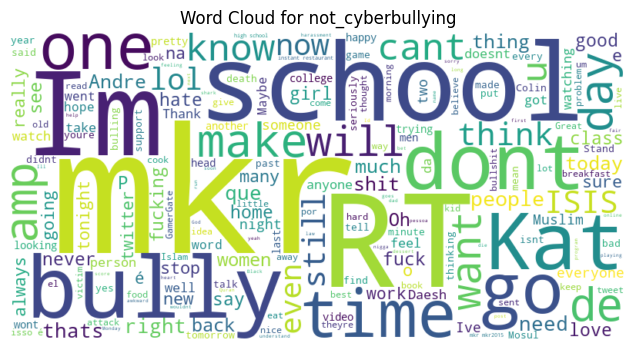

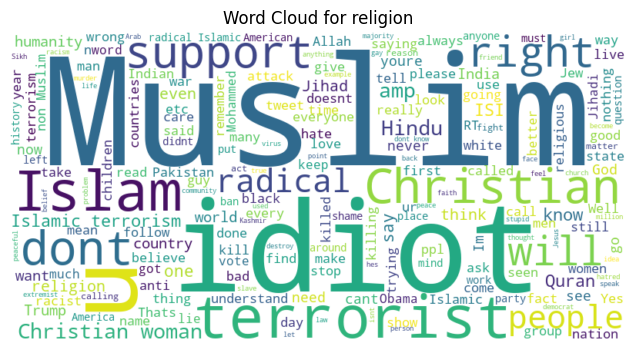

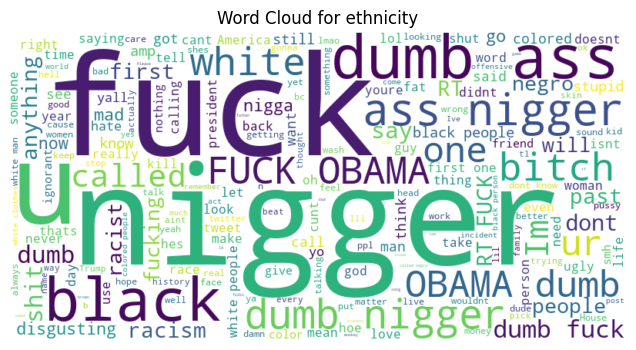

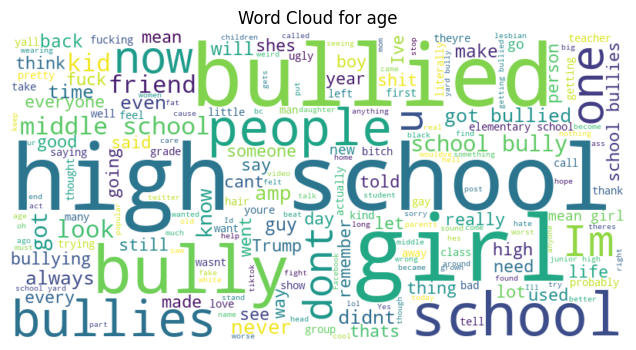

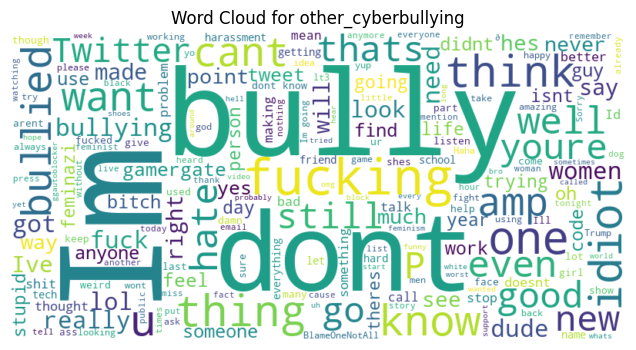

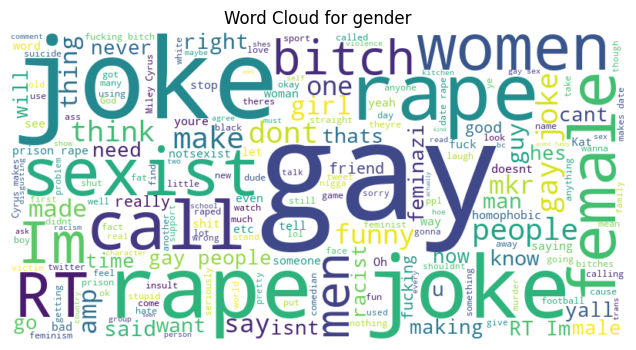

In [3]:
#generates a word cloud from the different categories
def createWordCloud(data, classification):
    
    #pulls ALL of the text associate with a class in the data and sizes them based on prominience
    text = ' '.join(data[data['cyberbullying_type'] == classification]['tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {classification}')
    plt.axis('off')
    plt.show()


for classification in df['cyberbullying_type'].unique():
    createWordCloud(df, classification)

#### These word clouds let you visualize how your model sees your classifications and allow you to adjust accordingly.

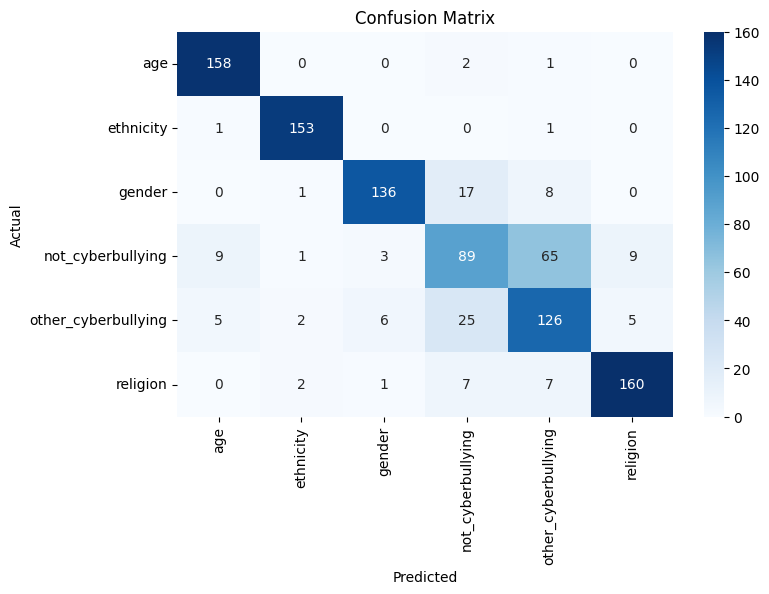

In [4]:
#creates a confusion matrics based on the test results
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Cyberbully Prediction Test Results')
plt.tick_params(axis='x', rotation=45)
plt.show()

#### This confusion matrix elegantly provides an inside look into the testing process. It includes how many classifications 
#### the model got right (true positives) as well as wrong (false positives) and what category was alternatively selected.

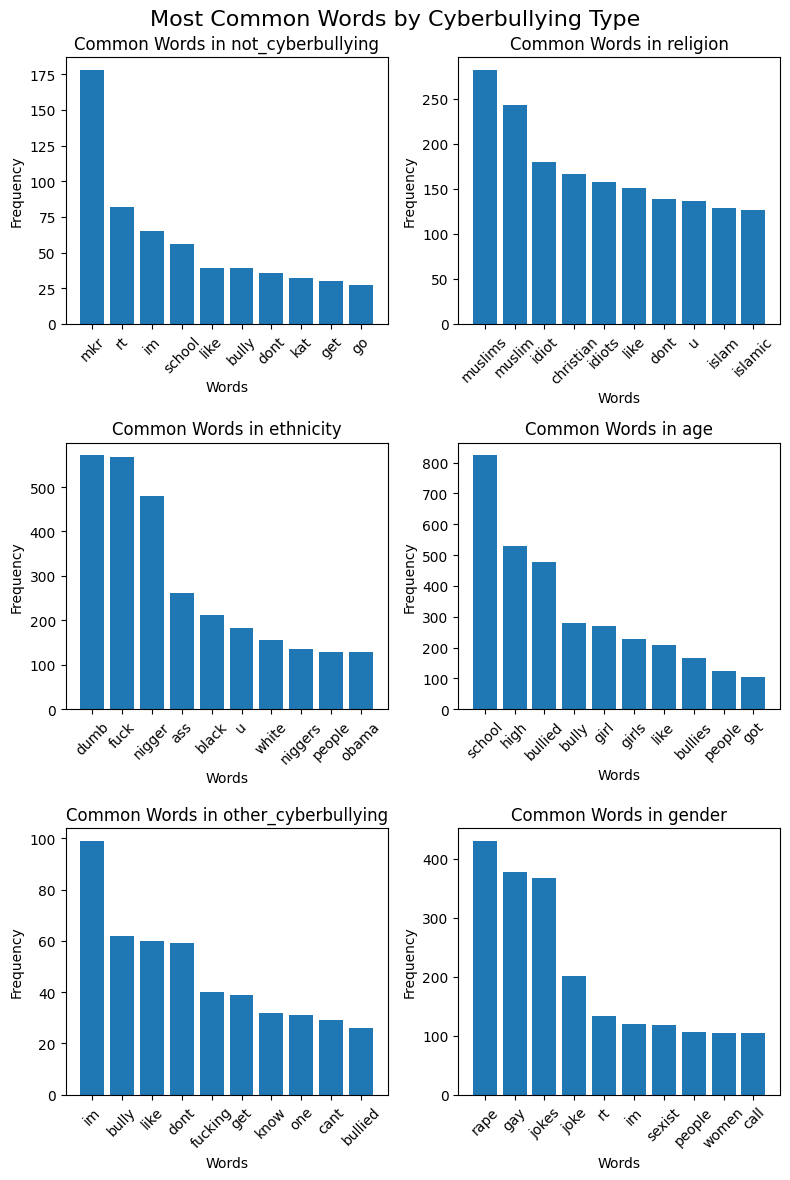

In [9]:
 #load stop words
stop_words = set(stopwords.words('english'))

#remove common english words when specifying top contributors
def processTweet(tweet):

    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet_tokens = word_tokenize(tweet.lower())

    tweet_tokens = [token for token in tweet_tokens if token not in stop_words]

    return ' '.join(tweet_tokens)  

df['processed_tweets'] = df['tweet'].apply(processTweet)

#get word frequencies by category
def getFrequency(data, classification):

    classification_all_words = ' '.join(data[data['cyberbullying_type'] == classification]['processed_tweets'])
    words = classification_all_words.split() 

    return Counter(words)

#group the frequent words together
frequent_words = {classification: getFrequency(df, classification) for classification in df['cyberbullying_type'].unique()}

#the number of words we allow in the graph
word_allowance = 10

#sets up the rows and columns for multi-graph
classifications = len(frequent_words)
fig, flaxes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))


flaxes = flaxes.flatten()

#creates a bar graph for each classification
for i, (classification, frequency) in enumerate(frequent_words.items()):

    top_words = frequency.most_common(word_allowance)
    
    words = []
    counts = []
    
    #populates the top words and their frequency count
    for word, count in top_words:
        words.append(word)
        counts.append(count)

    #each classification gets a bar chat with its top words and count
    flaxes[i].bar(words, counts)
    flaxes[i].set_title(f'Common Words in {classification}')
    flaxes[i].set_xlabel('Words')
    flaxes[i].set_ylabel('Frequency')
    flaxes[i].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

#### These bar graphs present the words most frequently associated with the different classifications in a classic, easily interpretable way.

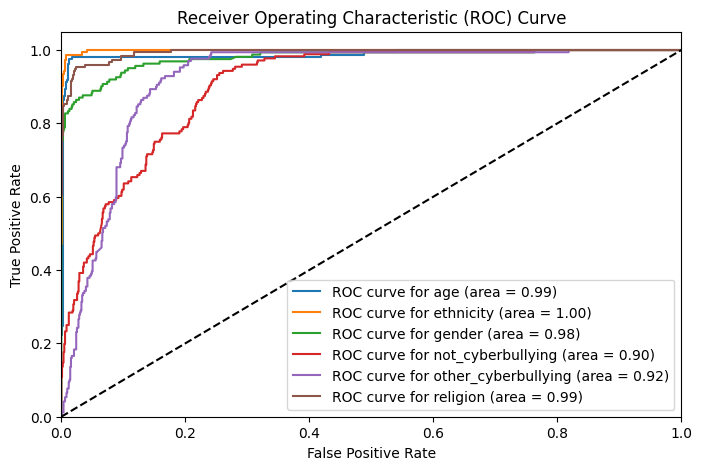

In [10]:
#create ROC graph

#data needs to be binary to work with the roc graph
y_test_binarize = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_score = svm_model.predict_proba(X_test_vector)

#create dictionaries to store the rates for each class
false_rate = dict()
true_rate = dict()
roc_lower = dict()

for i in range(len(label_encoder.classes_)):

    #calculate the false and true positive rates
    false_rate[i], true_rate[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    
    #scale the graph 
    roc_lower[i] = auc(false_rate[i], true_rate[i])

#plot the chart
plt.figure(figsize=(8, 5))
for i in range(len(label_encoder.classes_)):
    plt.plot(false_rate[i], true_rate[i], label=f'ROC curve for {label_encoder.classes_[i]} (area = {roc_lower[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cyberbullying Prediction ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### This ROC graph provides a snapshot of the model's prediction performance by category.